Last update: February 11, 2020  

コンタクト情報  
鵜山太智  
tuyama@ipac.caltech.edu

In [1]:
from PIL import Image

# 系外惑星の直接撮像

ここでは、系外惑星を直接観測する時のデータ解析を進めるためのプログラムを簡潔に示しています。
基本的なUnixやjupyterの使い方は橋本さん・片岡さんのテキストで学んでいると思うので、そちらは割愛します。

まず惑星を直接観測する時に必要なスペックはおおまかに3つあります。
(1) 暗い惑星を検出できる感度 (2) 惑星と星を見分ける空間分解能(視力みたいなものです) (3) 星の光を抑える高コントラスト技術

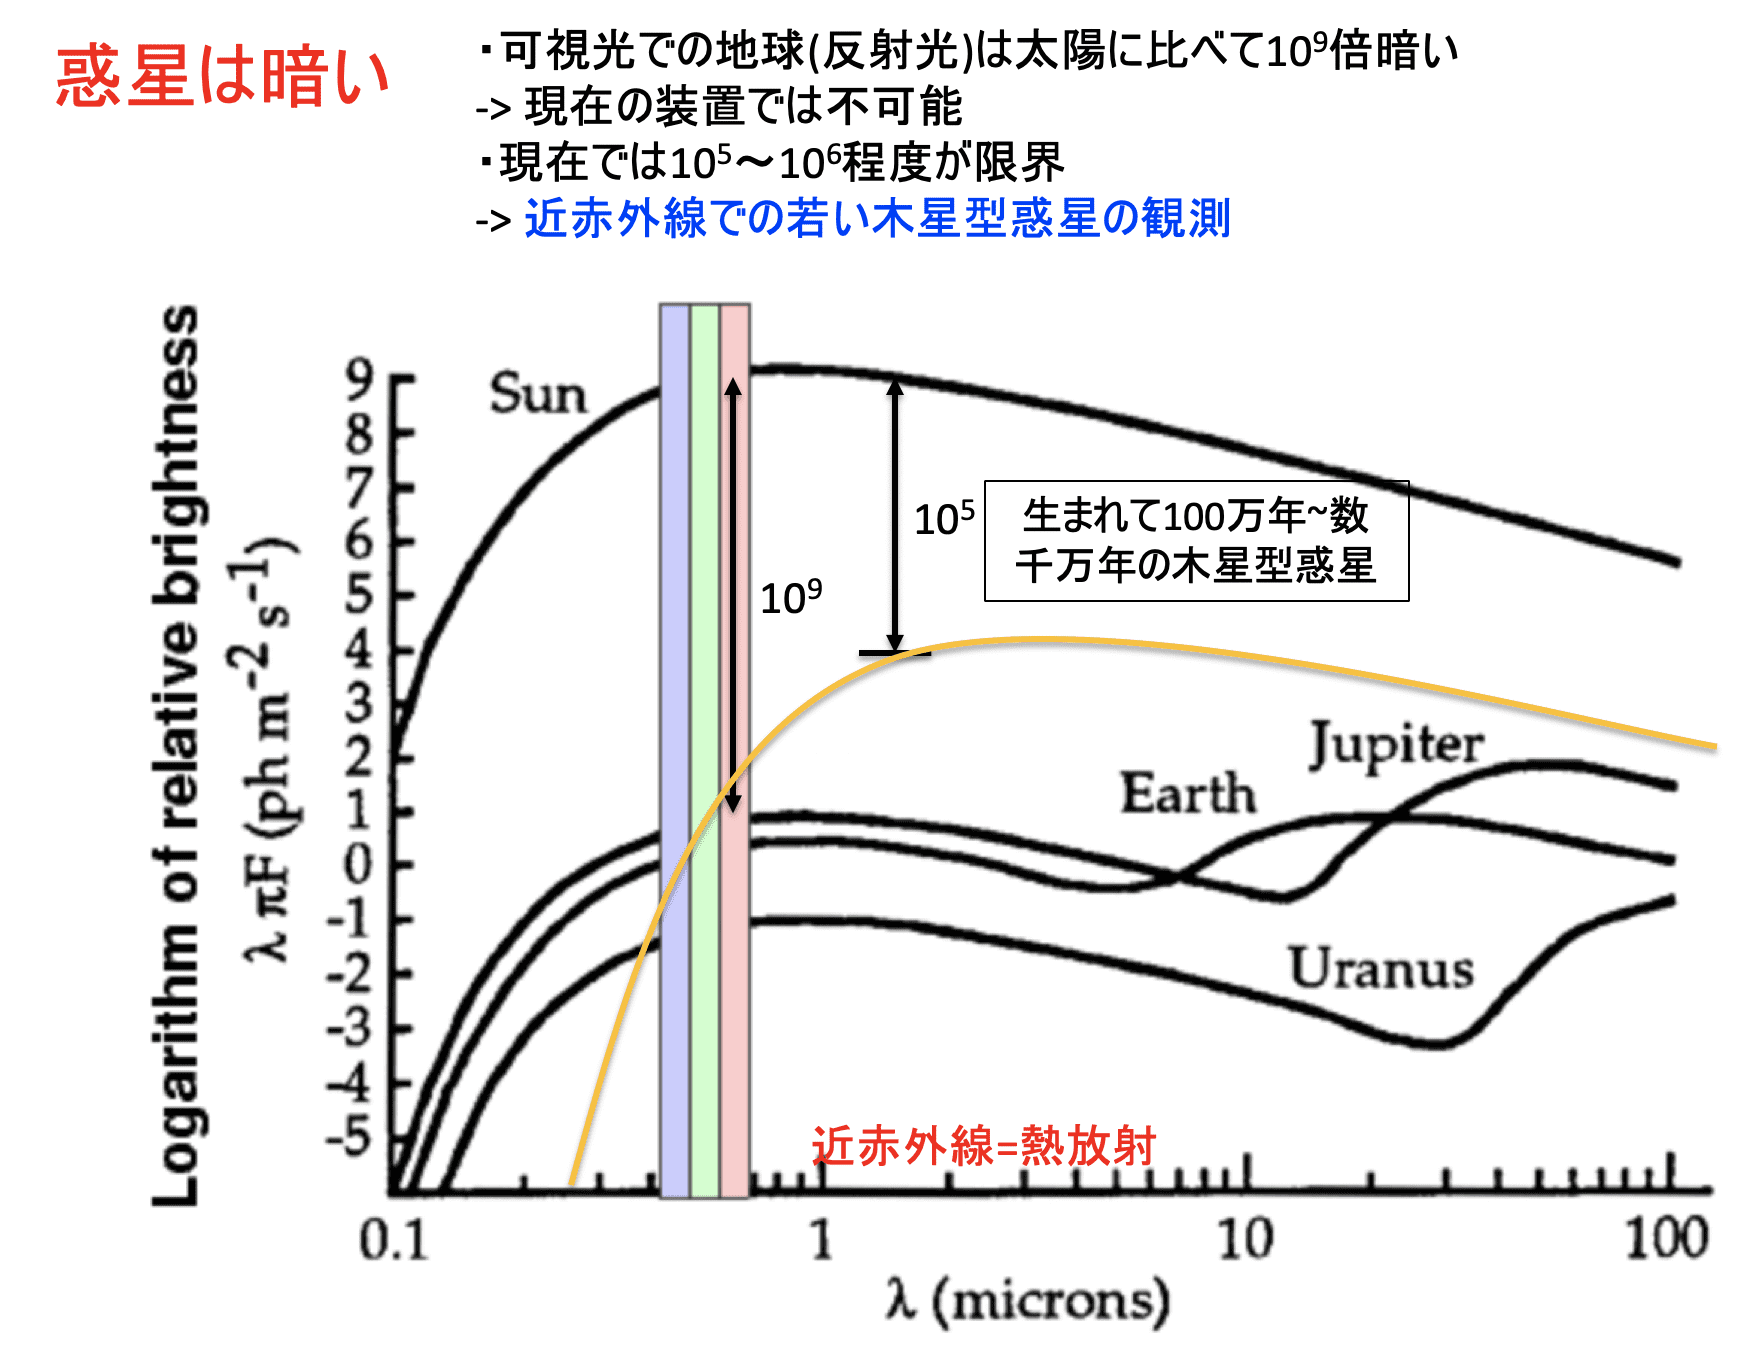

In [2]:
Image.open('tutorial_figs/SED_planets.png')

(1), (2)は国立天文台が運用するすばる望遠鏡@ハワイ(口径8m)のような大型望遠鏡で達成されています。しかし、(3)の高コントラストが大きな問題です。
暗い惑星はすぐ近くにある非常に明るい恒星の光に埋もれてしまい、惑星を見分けることがとても難しいからです。灯台のすぐ真横にある蛍を想像してください。
そのため他の観測手法(視線速度、トランジット、マイクロレンズ等)に比べて検出数は非常に少ないです。ただ、「百聞は一件にしかず」という言葉の通り、惑星の存在を画像で示すことができるのはこの方法が唯一であり、非常に重要な情報を得ることができます。
そのため、この高コントラスト問題を克服するために、天文学者は様々な観測・データ解析技術の開発に勤しみました。
まず観測段階で太陽の光を物理的に隠す「コロナグラフ」と、大気の乱れから星の像が歪む影響を補正する「補償光学」が開発されました。

関連リンク: https://subarutelescope.org/Introduction/instrument/j_AO.html

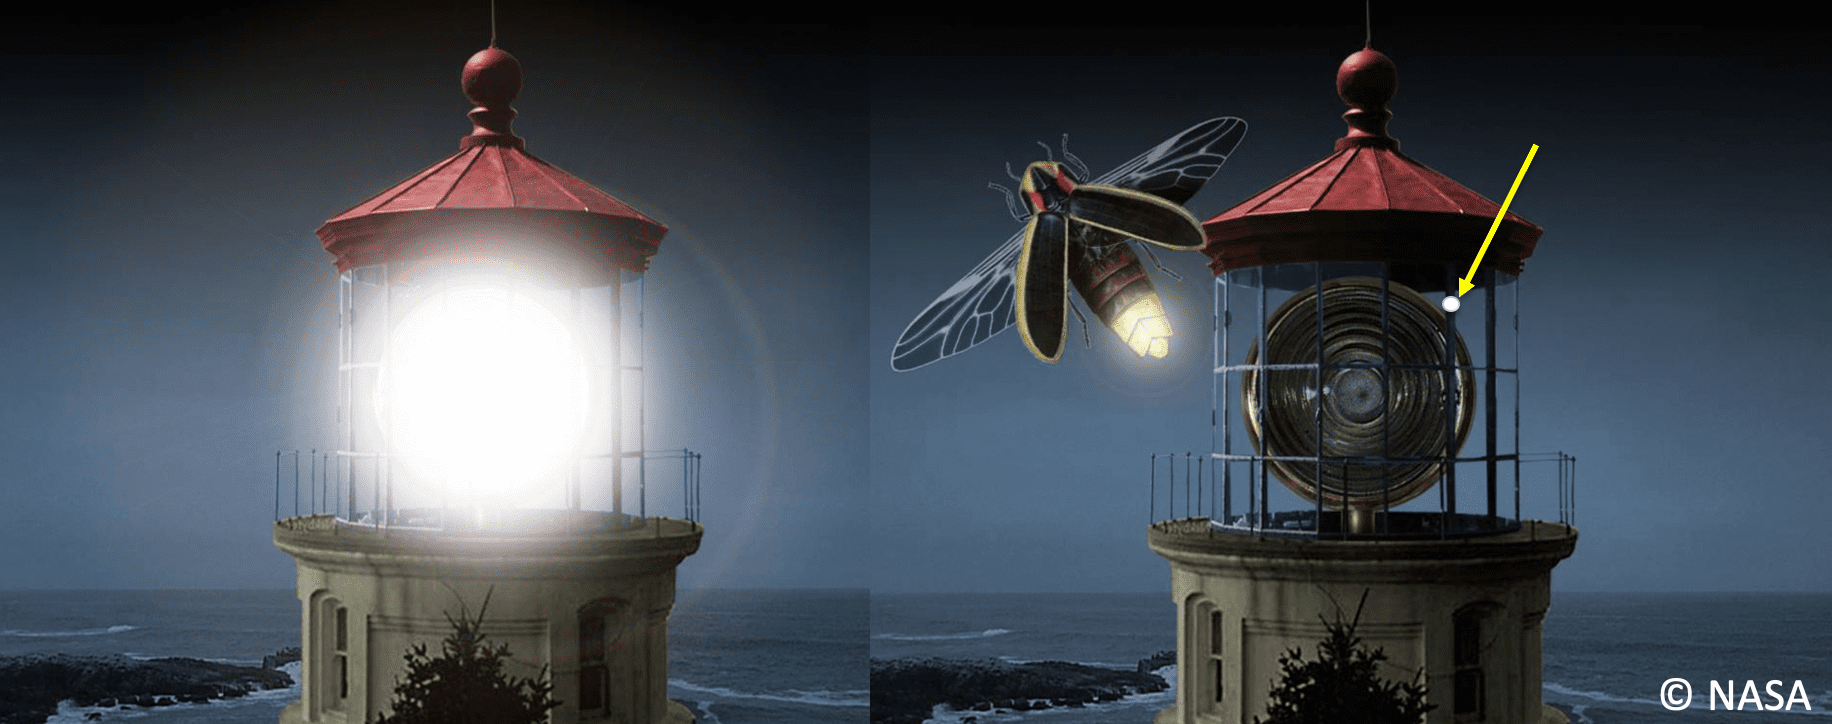

In [3]:
Image.open('tutorial_figs/lighthouse.png')

しかし、これらの技術だけでは現状まだ星の光を完全に取り除いて惑星の光を検出するのはまだまだ難しいです。
実際に画像を取得すると、星像(Point Spread Function: PSF)に特有のパターン(スペックル)が生じ、惑星のシグナルを隠してしまいます。要するにノイズです。
そこで、差分撮像法(differential imaging)を利用して更にノイズとなる星の光を取り除きます。今回は、その中でも特に惑星探査に有用な角度差分撮像法(Angular Differential Imaging; ADI)を利用しています。

下の図は簡単なADIの説明です。星座をイメージしてもらえたらと思うんですが、水平線上と南中した時では見え方(角度)が異なります。
なので、星とその周囲を回る惑星があるとすると、その位置関係は時間によって変わります。一方で、ノイズ成分は装置から由来するものなので、観測中に生じる惑星の回転に関係なく(基本的に)一定の位置に存在します。  
なので、異なる位置関係での画像を複数枚取得すれば、ノイズ成分のみを抽出することが可能です。これをreference PSFと呼びます。このノイズ成分となるものを、元の画像から差し引きすると、残るものは、回転している惑星部分のみになってきます。
最終的にそれらのシグナルが大きくなるように、各画像の回転部分を修正して結合させると、惑星のシグナルが得られるという仕組みです。

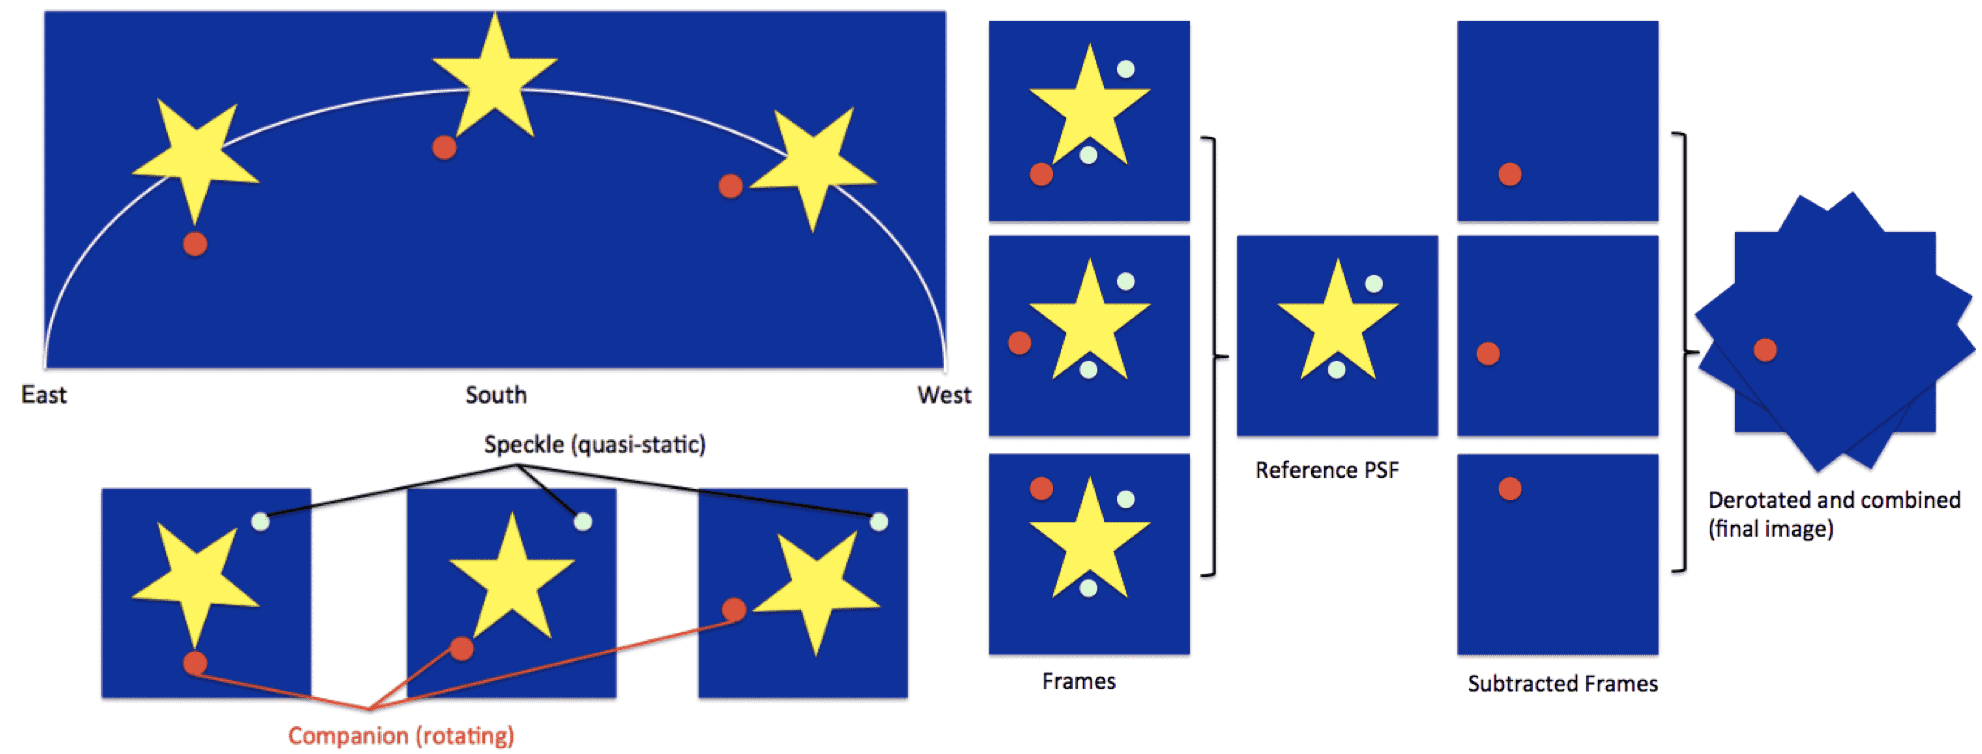

In [4]:
Image.open('tutorial_figs/ADI.png')

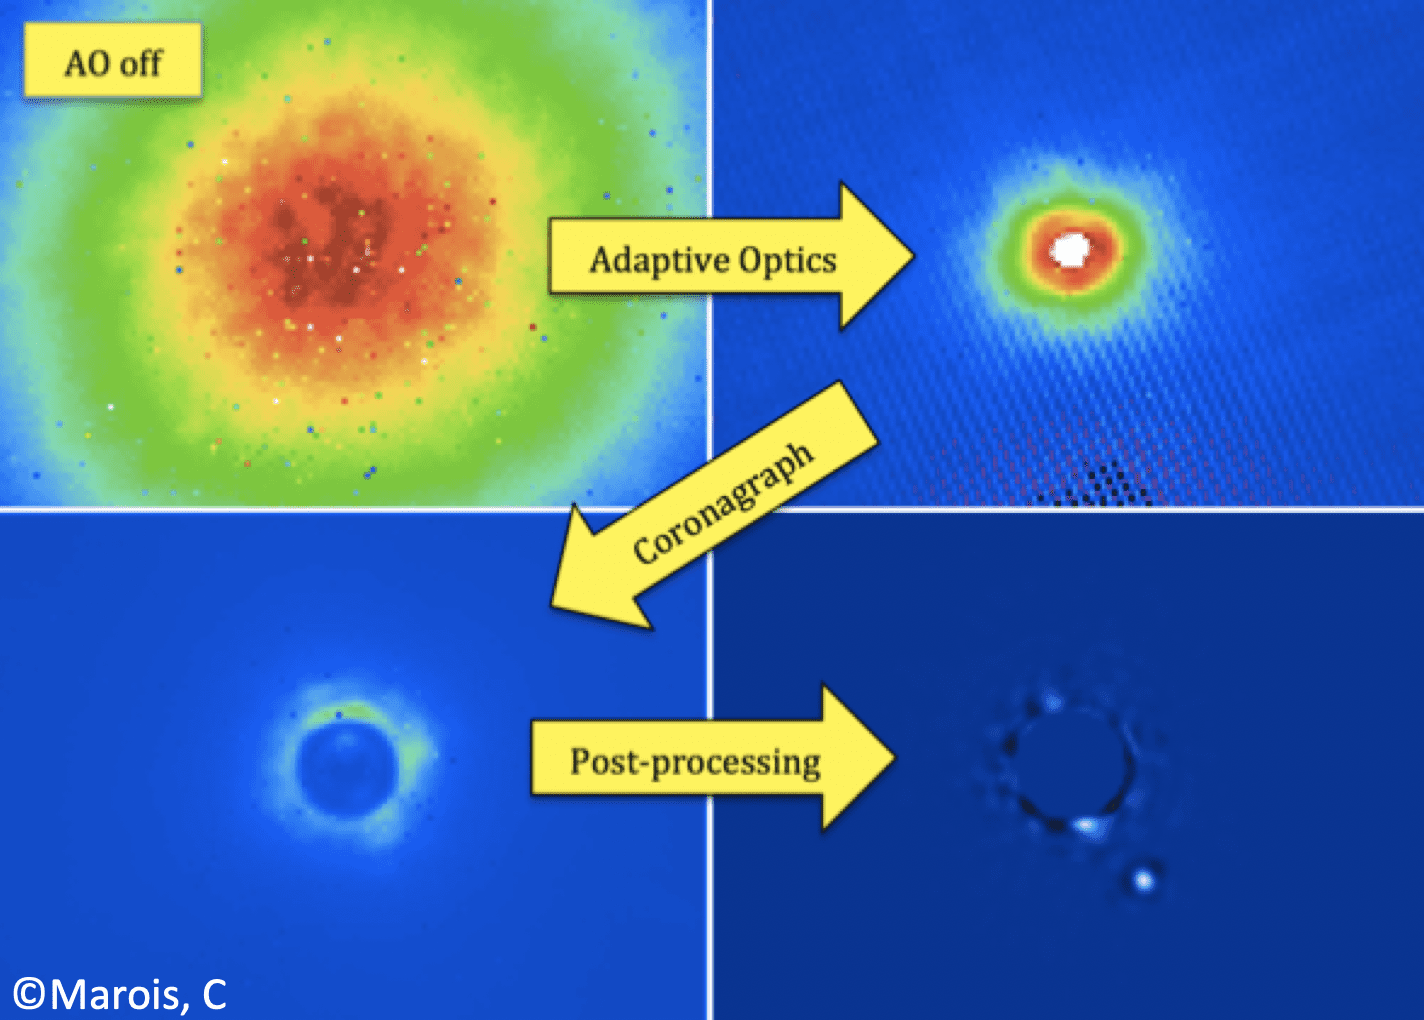

In [5]:
Image.open('tutorial_figs/schematic_DI.png')

さて今回は円盤ターゲットの一つであるJ1604に対して、実際に観測されたデータを使用しています。データは、日本の所有するすばる望遠鏡のお隣にあるケック望遠鏡(口径約10m)を使って取られました。  
若干ネタバレになりますが、実はこの天体ではまだ惑星が確認されていないので(世界をリードしている望遠鏡の観測でもこんなもんですアタリはなかなかやってきません笑、なんで日々研究者が頑張って探しています)、今回は惑星があった場合を想定して、元のデータに偽の惑星のシグナルをいくつか埋め込んでいます。実際にデータ解析を進めて、どの結果が惑星のシグナルになるのか、探してみましょう。

実際の観測データは、上で説明した星の光のノイズ以外にも、基本的に毎回観測で生じる装置由来のノイズがあります。それらは、事前に補正済みです。興味がある人は、ダーク、フラット、バイアス等調べてみて下さい、時間の都合上今回はここは取り扱いません。

さてここで上の説明をおさらいしておきましょう。  
・今から何をしますか？  
・ノイズになるものは何でしょうか？

データ解析を始める前に、今回のコードは"python 2.7"を想定してあります。python 3を普段使っている人は、お手数おかけして申し訳ないですが、python 2.7を使える環境を準備していただきたいです。
あとデータ解析にpyklipという特別なライブラリをインストールしておく必要があります。
そのためにいくつか設定してもらいたいことがあります。  

### 0)多波長解析システムを使っている人、python 3しかパソコンに入っていない人  
anacondaという環境構築プログラムを使ってpython 2.7とpyklipを使えるようにします。  
https://qiita.com/t2y/items/2a3eb58103e85d8064b6  
多波長解析システムを使っている方はこちらの「Linuxでのインストール方法」を、自前のパソコンでanacondaを入れたい方は、各自OSに合わせたインストール方法を参考にしてください。
ただし、このリンク先ではpython3.xを推奨していますが、今回はpython2.7を選んでください

その後、anacondaでpykipの使える環境を設定します。  
conda create -n pyKLIPenv python=2.7 numpy scipy astropy matplotlib mkl-service  
をコピーしてターミナルで打ってください。その後 'Proceed ([y]/n)?'と尋ねられるので、そのままEnterを打ちます。これで環境の設定は完了です。
最後に、

To activate this environment, use:  
source activate pyKLIPenv

と表示されるのですが、これに従ってターミナルで  
source activate pyKLIPenv
と打ち込んでください。そうすれば今設定した環境下でpythonを使えます。ただ、jupyter notebookでこのテキストを見られている方は、一度このテキストを出てもらって、pyKLIPenvの環境下で再度jupyter notebookを立ち上げてください。

### 1)pyKLIPのインストール  
ターミナルで(場所はどこでもいいですが、ホームディレクトリが良いかと思います)  
git clone https://bitbucket.org/pyKLIP/pyklip.git  
と打つと、必要なファイルがダウンロードされます。もし0をせずにpyklipが見つからないと言われた時は、お手数ですが0に戻ってanacondaのインストール->環境構築をお願いします。  
その後、ls -tr で現在のディレクトリ内を確認するとpyklipディレクトリが一番最新のところに出てくると思います。そちらのディレクトリに移って、  
python setup.py develop  
と打つとpyklipの準備完了です。

参考リンク  
https://pyklip.readthedocs.io/en/latest/install.html  


ここまでの下準備が完了したら実際のデータ解析開始です。

### ひとつ注意なのですが、何か入力してくださいと書いているところ以外は、そのままなにも触らずCtrl(Shift)+Enterを押してください。いじっちゃうと後でエラーが起きると思います。

# 0. setup modules

In [ ]:
import astropy.io.fits as fits
import numpy as np
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
from pyklip.fakes import gaussfit2d
from matplotlib import pyplot as plt
%matplotlib inline

# 1. input parameters

ADI解析をするためのパラメータです。設定の理解までしなくていいので、このままで大丈夫です。

In [ ]:
# defining self-subtraction region, default = 0.75 
N_delta = 0.75 

# pyKLIP parameters
movement = 0 # minimum movement of pixel between frames
numbasis=[1, 5, 10, 20] # KL modes
# for other arguments you may directly edit following kernels (4 kernels in total have a command for pyKLIP)

# 2. read the unsat frame 

観測効率を最大限に高めるためには、できるだけ一枚あたりの積分時間(シャッターをしめるまでの露光時間)を長くする必要があります。ただし、長くしすぎると検出器の上限値を超える光が入る(サチュレーションを起こす、サチると言います)ため、ギリギリサチるかどうかの積分時間を設定して観測します。  
ただし、コロナグラフを使う場合は、星の像(PSF)の一部がカットされた状態になります。  
そのためPSFの形状を知るには、サチらないくらいの短い積分時間で取った画像(unsaturated frame)を使って調べます。これは基本的にメインのデータではないんですが、参照となるデータがないと議論が進まなくなるため、非常に重要です。  
このデータを元に、PSFの近似的な式(ガウシアン、モファットなどいくつか数式が定義されています)を利用してフィットしています。  
ここで、FWHMという言葉を覚えておいてください。日本語では半値全幅と言います、Wikipediaなどを見れば定義が載っています。
天文データでは、PSFがどれだけ広がっているかの指標になるんですが、これが二つの星像を見分ける基準となる大きさになります。つまり、このデータにおける空間分解能(視力)です。

In [ ]:
unsat = fits.getdata('original_data/psf_noscale.fits')
xcen_guess = len(unsat[1])/2
ycen_guess = len(unsat[0])/2
peak_psf, fwhm_psf, x_psf, y_psf = gaussfit2d(unsat, xcen_guess, ycen_guess, guessfwhm= 5, guesspeak= 10000, searchrad=10)

画像を確認してみましょう

In [ ]:
plt.imshow(np.flipud(unsat))
plt.colorbar()

## define inner working angle from FWHM

inner working angleというのは今回のデータでどれだけ内側(星の近く)まで有効なデータがあるかを、角距離で表したものです。
1°=60'(分) ,1'=60"(秒) というように、時間と同じ単位を使っていますが、れっきとした角度です。
ちなみに、系外惑星の直接撮像は、1"(=1/3600度)より内側という非常に短い距離にある、非常に暗い惑星のシグナルを見つけようとしています。

今回このコードの中で、inner working angleをFWHMから求めるという関数を定義して、これを後々使っています。

In [ ]:
def calc_iwa(fwhm,del_theta,N_delta):
    
    IWA = fwhm*N_delta/del_theta # inner working angle is set in pixel unit
    print "inner working angle is %s pix" %(int(IWA))
    
    return int(IWA)

# 3. reduce the science frames by ADI

### さて、ここからがADIデータ解析の肝です。データはtest_dataというディレクトリに test_1.fits, test_2.fits, test_3.fits と3つ入れてあります。
### どれを使ってもいいので、次の欄で指定してみてください。それぞれどのような惑星のシグナルが入っているかは、秘密です。

惑星探し開始！

In [ ]:
# change input frame
input_cube = fits.getdata('test_data/test_1.fits')

上で説明しましたが、サチュレーションを避けるために積分時間はある一定のところで区切り、同じ観測を何回も繰り返して、トータルの積分時間を稼ぐ必要があります。今回使うinput_cubeは、3次元構造をしており、x,y方向の2次元に加えて、それぞれの観測ごとのデータをまとめた3次元方向が存在しています。言い方を変えると観測時間になりますね。
それでは、そのうちの一枚を見てみましょう。  
例えば、input_cube[5]とすると、画像データを集めた３次元ファイルの6番目(pythonは0からカウントを始めます)の画像を開くことができます。この[ ]内の数字を変えると、それに対応した画像ファイルが出てきます。下の欄でこの数字の部分をcube_numberと定義してあります。この数字をいじって、他の画像を試しに見てみて下さい。今回画像の数は73なので、cube_numberは0から72まで入力可能です。

In [ ]:
cube_number = 5
plt.imshow(np.flipud(input_cube[cube_number]),
          vmin=0, vmax=9000)
plt.colorbar()

先ほどのサチっていない星のPSFと形状が違うのがわかるでしょうか？これはコロナグラフを置いているからなのですが、さてコロナグラフはどこにあるでしょう？  
また、この画像を見るだけでは惑星のシグナルが見えていません。そうするとコロナグラフ近くのもやもやしたものは何でしょうか？  
それらを把握した上で、これからADI解析を始めていきます。

## preparations

こちらも細かいパラメータ設定なので、今は気にせずCtrl+Enterで進んでください

In [ ]:
# Parallactic Angle list
PA_list = fits.getdata('original_data/2MJ16042165-213_angs_73sci.fits')

# check parallactic angle change
angoff = PA_list[-1] - PA_list[0]
if angoff< -180:
            angoff += 360
elif angoff > 180:
            angoff -= 360
# calculate IWA
del_theta = angoff*np.pi/180
iwa = calc_iwa(fwhm_psf,del_theta,N_delta)

# define center
xcen = len(input_cube[0][1])/2
ycen = len(input_cube[0][0])/2
centers = np.tile((xcen,ycen),len(input_cube)).reshape(len(input_cube),2)

#prepare dateset
dataset = Instrument.GenericData(input_cube, centers, parangs=PA_list, IWA=iwa)
dataset.flipx = False

## pyKLIP

実は下のコマンド一つだけでADI解析を全部行なっています。Ctrl+Enterを押すと、色々と文章がプリントされますが、気にせず結果を確認しましょう。  
また、このpyKLIPというライブラリは単純にデータ数を増やしてノイズを減らすのを行うだけでなく、「もっともらしい」ものを統計学的に計算してよりノイズを減らす操作を行なっています。気になる方は、主成分分析(Principal Component Analysis: PCA)を調べてみて下さい。

In [ ]:
parallelized.klip_dataset(dataset, outputdir="./", fileprefix="ADI", mode="ADI", annuli=10, subsections=1, movement=movement, numbasis=numbasis, maxnumbasis=100)

### -> output: ADI-KLmodes-all.fits

次のコマンドを走らせると、画像が4つ表示されます。これら全てデータ解析の結果なんですが、解析パイプライン内のパラメータ(KLと表示されているもの)が異なっています。これは、どれだけ「アグレッシブに」シグナルを差し引くか、を示すパラメータなのですが、今回はあまり気にしないでください。  
ここで大事なことは、表示される画像を比較して、それぞれの画像でシグナルがあったりなかったりするとノイズ、同じところにシグナルがあれば、それは「リアルっぽい」シグナルということです。さて惑星シグナルは見つかるでしょうか、確認してみてください。

In [ ]:
im = fits.getdata('ADI-KLmodes-all.fits')
hd = fits.getheader('ADI-KLmodes-all.fits')
plt.figure(figsize=(15,10))
for i in range(len(im)):
    KLmode = hd['KLMODE'+str(i)]
    plt.subplot(1,len(im),i+1)
    plt.title('KLmode='+str(KLmode))
    plt.imshow(np.flipud(im[i][ycen-100:ycen+100,xcen-100:xcen+100]),
              vmin=0,vmax=50)

# 5. make a SN map and a contrast curve

In [ ]:
import sys
sys.path.append('./contrast_code_python/')
import circ_conv
import noise_sn_map
import contrast_pr
import detection_limit

上の画像で惑星だと思われるものは見つけましたか？ただ、これだけ見せて惑星！と言うのは尚早です(「リアルっぽい」という表現を使ったのもそのためです)。研究者たるもの、定量的な議論が必要です。画像を見せるだけだと、定性的な議論で終わってしまいます。  
ここでは、それぞれ惑星と思われるシグナルがどれだけ「確からしい」のかを確認しましょう。
天文観測に限らずですが、SN比というものが大きな意味を持ちます。観測された結果がノイズなのか、リアルなのかを調べるための一つの指標です。これを画像に落とし込んでみましょう。
今回は簡単のために、KL mode=10とされている画像を最終的な結果として、調べたいと思います。もし違うKL modeの結果をみたい、と思われたら、下のinput parametersの欄にあるchannelの数字を変更してみてください。

|  channel (入力する数字) | KL mode |
|      :---:   |    :---:    |
|        0    |      1     |
|        1    |      5     |
|        2    |      10    |
|        3    |      20    |

・今何のシグナルを知りたいですか？  
・ノイズはどうやって調べますか？

## input parameters

In [ ]:
# aperture diameter (basically same as fwhm)
app_di = fwhm_psf

# input file and KL channel
input_file = 'ADI-KLmodes-all.fits'
channel = 3 # int - the channel of KL

# output
output_dir = './'

# exposure time (if not normalized)
exptime = 45.

# for making a noise profile
start_r = 10 # pix
rmax = 300 # pix
step = 10 #pix

## convolve a image (aperture photometry at each pixel)

この部分は少し難しいので、今回はCtrl+Enterだけで進めてしまってください。気になる方は、畳み込み(Convolution)を調べてみてください。それを画像で行っています。

In [ ]:
im = fits.getdata(input_file)[channel-1] # convolved image
hd = fits.getheader(input_file) # and its header

kernel = circ_conv.make_aperture(app_di) # make convolution kernel

conv_output = circ_conv.circ_conv(im, kernel, exptime) # make convolved image

hd.set("normtime", str(exptime), 'normalized by this value')
hd.set("convD", str(round(app_di)), 'convolution with this diameter aperture')

fits.writeto(output_dir+'conv_D'+str(round(app_di))+"_ch"+str(channel)+'_'+input_file, conv_output, hd,overwrite=True) # output

## make a noise profile

ここでノイズを半径の関数として出力しています。コードの関係上、出力された結果を元のターミナルを使って新しいファイルにセーブしてください。
jupyterを走らせているところと同じディレクトリで  
'$emacs noise.dat'  
をターミナルでうち、コピー&ペーストしてセーブしてください。

In [ ]:
conv_im = fits.getdata('conv_D'+str(round(app_di))+"_ch"+str(channel)+'_'+input_file)
print '# Radius, anulus radius median, Mean, Standard Deviation'
contrast_pr.contrast_pr(conv_im,fwhm_psf,rmax,xcen,ycen,start_r=start_r,mode='entire', step=step,cliping=5.)

## make a SN map

さて上のところでノイズが計算されています。ノイズがわかったので、SN比を計算したいと思います。シグナルは、データ解析結果それぞれのピクセルだと思ってください。それをノイズで割ると、各ピクセルでのSN比が計算されます。なので、SNマップを作ることができます。

In [ ]:
#### read noise.dat ###
noise_data = np.loadtxt('noise.dat', usecols=(0,3), dtype=str)

sep = np.array(noise_data[:,0], dtype=float)
oned_noise = np.array(noise_data[:,1], dtype=str)

####### remove nan ############ 
nan_sep = np.where(oned_noise != 'all_nan')
oned_noise = oned_noise[nan_sep]
sep = sep[nan_sep]
###############################

oned_noise = np.array(oned_noise, dtype=float)
noise = noise_sn_map.noise_interp(im, sep, oned_noise)

noise_sn_map.snmap(conv_im, noise)

### -> output: snmap.fits, noise_map.fits

snmap.fits がSNマップ、こちらを使います。noise_mapは各ピクセルでのノイズの値を示したものです。こちらは今気にしなくて大丈夫です。
一般的に、SN=5が検出かどうかの基準です。下のコードを走らせて、SNマップを確認してみましょう。

・SN=5は何パーセント確からしいと言えるでしょうか？

In [ ]:
snmap = fits.getdata('snmap.fits')
plt.imshow(np.flipud(snmap[ycen-100:ycen+100,xcen-100:xcen+100]),
          vmin = -1, vmax = 5)
plt.colorbar()

今回は、時間の関係上データ解析をしてシグナルを探すところで終わります。しかし、ここでまだ終わりではありません。実際にこれらのシグナルがリアルだったとして、宇宙には沢山の天体が存在します。これだけを見て、惑星と言えるでしょうか？  
答えはNOです。ここから、さらにこれらのシグナルが惑星であることを調べる作業が必要になってきます。
最初は気の遠くなるような難しい作業に思えるかもしれませんが、一度流れを把握してコードを準備できれば、あとは比較的単純な作業です。
これら全てのプロセスを通して、誰も探査したことのない星の周りにある惑星を自分の手で探し求めることができます。

## make a contrast curve

最後に、惑星が見つからなかったとしてそのデータは用無しになるかというと、そうではありません。「ない」事を示すのも重要な成果です。
直接撮像の観測者たちは、「検出限界」を作成することで、それを示しています。主星からどれだけ離れたところに、どういった天体が存在しないかということを示しています。これを先ほど得られた画像から作成しましょう。

見つからない、ということはもし惑星が存在していても、今回の観測データではSNが5より小さかったということです。
なので、ノイズの結果を元に、中心星の明るさと比較した「コントラスト」として出力します。

In [ ]:
### read unsat PSF information ###
unsat_hdr = fits.getheader('original_data/psf_noscale.fits')
itime_unsat = unsat_hdr['ITIME']
coadds_unsat = unsat_hdr['COADDS']
exp_unsat = itime_unsat*coadds_unsat
phot_unsat = unsat_hdr['STARPHOT']
#####

detection_limit.calc_contrast('noise.dat',phot_unsat/exp_unsat)

### output-> contrast.dat
### Note: flux-loss calibration is not done yet!

### plot 5sigma contrast limit

さてこれを画像にしてみましょう。今回のデータで、J1604の周囲でどれくらいの明るさの天体が「ない」事を示せたでしょうか？

・データによっては、ギザギザが起こることがあります。それは、何を意味しているでしょうか？

In [ ]:
contrast_data = np.loadtxt('contrast.dat')
plt.plot(contrast_data[:20,0],contrast_data[:20,1])
plt.xlabel('separation [pix]')
plt.ylabel('contrast')
plt.yscale('log')

これで系外惑星の直接撮像データ解析体験は終わりになります、お疲れ様でした！  
余談になりますが、僕が大学4年の時にやっていた卒業研究と同じくらいの分量・内容です(さすがに自分でコード作ったりはしてません笑)。
大学4年生であれば、僕と同じタイミングで、また大学3年生までであれば僕より早く研究に足を踏み入れた事になります。  
ここからは自分次第の頑張り(とアタリを引く運の良さ)です。道中の難しさを楽しみながら、また様々な人と協力しながら楽しんで研究してください！

### 注意:最後までコードを走らせた後、3.に戻って違うテストデータで試される際は、生成ファイルが上書きされてしまいます。残しておきたいという方は、3.に戻る前に一つディレクトリを作って、そちらに生成されたファイルを移しましょう。それから再度データ解析してみてください。
上書きされるファイル: ADI-KLmodes-all.fits, snmap.fits, noise_map.fits, noise.dat, contrast.dat

## 答え合わせ
埋め込んだシグナルですが、answer\_data.zipに入っています。ただ、これにはパスワードがかけてあります。全部終わった時にパスワードを教えるので、そのあとに下のコマンドを走らせてください。どの位置にどの明るさの惑星シグナルがあったか確認できます。  
その際、下の欄でデータを指定してください。answer\_data/answer\_[1,2,3].fits の1,2,3はテストデータとリンクしています。

In [ ]:
answer = fits.open('answer_data/answer_1.fits')

In [ ]:
answer_im = answer[0].data
plt.imshow(np.flipud(answer_im[ycen-100:ycen+100,xcen-100:xcen+100]))

In [ ]:
answer_hd = answer[0].header

num_psf = answer_hd['N_PSF']
print '埋め込んだ惑星シグナルの数: %s' %(str(num_psf))
cont = answer_hd['CONTRAST']

for i_psf in range(num_psf): 
    r = answer_hd['R'+str(i_psf+1)]
    theta = answer_hd['THETA'+str(i_psf+1)]
    print 'シグナル%s: 距離 %s(ピクセル)、角度 %s (度)、コントラスト %0.1e' % (str(i_psf+1), str(r), str(theta), cont)


データ解析した結果と比べてみてください。見つかるものと見つからないものがあると思いす、さてこの差はなぜ起きるでしょうか？  
答えは、これまでに習った内容を理解していれば分かると思います。